In [1]:
import os
import sys
import warnings
import numpy as np
import dask.distributed as dd
from dask.utils import format_bytes
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from dateutil.parser import parse
from aqua import Reader, util, logger
from datetime import datetime
from aqua.exceptions import NotEnoughDataError, NoDataError, NoObservationError
import pandas as pd
import argparse


import cartopy.crs as ccrs
import cartopy.feature as cfeature

#logger = logger.log_configure(log_level='INFO', log_name='ssh_logger')


In [2]:
config = util.load_yaml('../config1.yml')


In [3]:
logger = logger.log_configure(log_level='INFO', log_name='ssh_logger')


In [4]:
pwd

'/work/ab0995/a270238/work/AQUA/diagnostics/ssh_jal/notebooks'

In [8]:
reader = Reader(model="ICON", exp="ngc3028", source="P1D",regrid = 'r025',zoom ="7", fix=True)

KeyError: 'regrid'

In [81]:
data = reader.retrieve()
data.zos


2023-11-21 12:13:53 :: eccodes :: WARNING  -> ShortName tprate have multiple grib codes associated: ['260048', '172228']
2023-11-21 12:13:53 :: eccodes :: WARNING  -> AQUA will take the first so that tprate -> 260048, please set up a correct fix if this does not look right
2023-11-21 12:13:53 :: eccodes :: WARNING  -> ShortName vo have multiple grib codes associated: ['262503', '138']
2023-11-21 12:13:53 :: eccodes :: WARNING  -> AQUA will take the first so that vo -> 262503, please set up a correct fix if this does not look right


<xarray.DataArray 'zos' (time: 2010, cell: 196608)>
dask.array<open_dataset-zos, shape=(2010, 196608), dtype=float32, chunksize=(1, 196608), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2020-01-21 2020-01-22 ... 2025-07-22
Dimensions without coordinates: cell
Attributes:
    cell_methods:  time: mean cell: mean
    component:     ocean
    grid_mapping:  crs
    long_name:     zstar sfc elevation at cell center
    units:         m
    vgrid:         surface

In [82]:
def check_time_span(config, ds, start, end):
    """
    Check if the required time span defined by start and end is within the 
    time span of the xarray data.

    Parameters:
    - ds: xarray Dataset or DataArray with a time coordinate.
    - start: Start of the required time span.
    - end: End of the required time span.

    Returns:
    - bool: True if the required time span is within the xarray data's time span, False otherwise.
    """
    #aqua_logger = logger.log_configure(log_level=config['log_level'], log_name=config['log_name'])

    # Convert start and end strings to datetime objects
    start_date = datetime.strptime(start, '%Y-%m-%d')
    end_date = datetime.strptime(end, '%Y-%m-%d')

    #aqua_logger.debug("start_date: %s", start_date)
    #aqua_logger.debug("end_date: %s", end_date)

    # Extract the time coordinate from the xarray data
    time_coord = ds['time']

    # Ensure the min and max time coordinates are in datetime format for comparison
    time_min = pd.to_datetime(time_coord.min().values)
    time_max = pd.to_datetime(time_coord.max().values)

    #aqua_logger.debug("time_min: %s", time_min)
    #aqua_logger.debug("time_max: %s", time_max)

    # Check if the config specifies checking for the complete time span
    if config.get('check_complete_timespan', False):
        return True
    else:
        # Check if the required time span is within the xarray data's time span
        return start_date >= time_min and end_date <= time_max


In [83]:
for model_name in config['models']:

            try:
                reader = Reader(model=model_name['name'], exp=model_name['experiment'],
                            source=model_name['source'], regrid=model_name['regrid'], zoom=model_name['zoom'], fix=True)
            except:
                raise NoDataError("Model data not found.")
                
            model_data = reader.retrieve()

            ssh_data = model_data[model_name['variable']]
            if 'timespan' in model_name and model_name['timespan']:
                if not check_time_span(config, ssh_data, model_name['timespan'][0], model_name['timespan'][1]):
                    raise NotEnoughDataError("The time span is not within the range of time steps in the xarray object.")
                    sys.exit(0)
                timespan_start = parse(model_name['timespan'][0])
                timespan_end = parse(model_name['timespan'][1])

            else:
                warnings.warn(
                    "Model does not have a custom timespan, using default.", UserWarning)

2023-11-21 12:13:58 :: eccodes :: WARNING  -> ShortName tprate have multiple grib codes associated: ['260048', '172228']
2023-11-21 12:13:58 :: eccodes :: WARNING  -> AQUA will take the first so that tprate -> 260048, please set up a correct fix if this does not look right
2023-11-21 12:13:58 :: eccodes :: WARNING  -> ShortName vo have multiple grib codes associated: ['262503', '138']
2023-11-21 12:13:58 :: eccodes :: WARNING  -> AQUA will take the first so that vo -> 262503, please set up a correct fix if this does not look right
2023-11-21 12:14:41 :: eccodes :: WARNING  -> ShortName sst have multiple grib codes associated: ['34', '151159']
2023-11-21 12:14:41 :: eccodes :: WARNING  -> AQUA will take the first so that sst -> 34, please set up a correct fix if this does not look right
2023-11-21 12:14:41 :: eccodes :: WARNING  -> ShortName vo have multiple grib codes associated: ['262503', '138']
2023-11-21 12:14:41 :: eccodes :: WARNING  -> AQUA will take the first so that vo -> 2625

In [4]:
import sys
sys.path.insert(0, '../../')
from ssh_jal import sshVariability

In [5]:
%%time
analyzer = sshVariability('../config1.yml')
#analyzer.run()
# runtime is around 7-8 min depending on how much data you wish to analyse.

CPU times: user 7.9 ms, sys: 1.82 ms, total: 9.72 ms
Wall time: 29.1 ms


In [45]:
def check_time_span(ds, start, end):
    """
    Check if the required time span defined by start and end is within the 
    time span of the xarray data.

    Parameters:
    - ds: xarray Dataset or DataArray with a time coordinate.
    - start: Start of the required time span.
    - end: End of the required time span.

    Returns:
    - bool: True if the required time span is within the xarray data's time span, False otherwise.
    """

    # Convert start and end strings to datetime objects
    start_date = datetime.strptime(start, '%Y-%m-%d')
    end_date = datetime.strptime(end, '%Y-%m-%d')

    logger.debug("start_date: %s", start_date)
    logger.debug("end_date: %s", end_date)

    # Extract the time coordinate from the xarray data
    time_coord = ds['time']

    # Ensure the min and max time coordinates are in datetime format for comparison
    time_min = pd.to_datetime(time_coord.min().values)
    #time_min = time_min.replace(hour=0, minute=0, second=0, microsecond=0)
    time_max = pd.to_datetime(time_coord.max().values)
    #time_max = time_max.replace(hour=0, minute=0, second=0, microsecond=0)


    logger.debug("time_min: %s", time_min)
    logger.debug("time_max: %s", time_max)

    # Check if the required time span is within the xarray data's time span
    return start_date >= time_min and end_date <= time_max

In [46]:
check_time_span(config, aviso_ssh, timespan_start, timespan_end)

TypeError: check_time_span() takes 3 positional arguments but 4 were given

In [64]:
config = util.load_yaml('../config1.yml')


In [34]:

try:
    reader = Reader(model=config['base_model']['name'], exp=config['base_model']
                        ['experiment'], source=config['base_model']['source'], fix=True)
except:
    raise NoObservationError("AVISO data not found.")

2023-11-21 11:12:31 :: Reader :: WARNING  -> No fixes available for model AVISO


In [35]:
aviso_cat = reader.retrieve()
timespan_start = config['timespan']['start']
timespan_end = config['timespan']['end']


In [15]:
aviso_cat


<xarray.Dataset>
Dimensions:         (time: 10766, latitude: 720, longitude: 1440, nv: 2)
Coordinates:
  * latitude        (latitude) float32 -89.88 -89.62 -89.38 ... 89.62 89.88
  * longitude       (longitude) float32 -179.9 -179.6 -179.4 ... 179.6 179.9
  * nv              (nv) int32 0 1
  * time            (time) datetime64[ns] 1993-01-01 1993-01-02 ... 2022-06-23
Data variables: (12/14)
    adt             (time, latitude, longitude) float64 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    crs             (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    err_sla         (time, latitude, longitude) float64 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    err_ugosa       (time, latitude, longitude) float64 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    err_vgosa       (time, latitude, longitude) float64 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    flag_ice        (time, latitude, longitude) float64 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    ...              ...
    sla             (time, latitude, longitude) float64 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    tpa_correction  (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    ugos            (time, latitude, longitude) float64 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    ugosa           (time, latitude, longitude) float64 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    vgos            (time, latitude, longitude) float64 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    vgosa           (time, latitude, longitude) float64 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
Attributes: (12/44)
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Grid
    comment:                         Sea Surface Height measured by Altimetry...
    contact:                         http://climate.copernicus.eu/c3s-user-se...
    creator_email:                   http://climate.copernicus.eu/c3s-user-se...
    ...                              ...
    summary:                         SSALTO/DUACS Delayed-Time Level-4 sea su...
    time_coverage_duration:          P1D
    time_coverage_end:               1993-01-01T12:00:00Z
    time_coverage_resolution:        P1D
    time_coverage_start:             1992-12-31T12:00:00Z
    title:                           DT merged two satellites Global Ocean Gr...

In [16]:
aviso_cat.adt[0:2].time

<xarray.DataArray 'time' (time: 2)>
array(['1993-01-01T00:00:00.000000000', '1993-01-02T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1993-01-01 1993-01-02
Attributes:
    axis:           T
    long_name:      Time
    standard_name:  time

In [17]:
aviso_ssh = aviso_cat['adt']


In [18]:
aviso_ssh


<xarray.DataArray 'adt' (time: 10766, latitude: 720, longitude: 1440)>
dask.array<open_dataset-adt, shape=(10766, 720, 1440), dtype=float64, chunksize=(1, 720, 1440), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * longitude  (longitude) float32 -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
  * time       (time) datetime64[ns] 1993-01-01 1993-01-02 ... 2022-06-23
Attributes:
    comment:        The absolute dynamic topography is the sea surface height...
    grid_mapping:   crs
    long_name:      Absolute dynamic topography
    standard_name:  sea_surface_height_above_geoid
    units:          m

In [14]:
check_time_span(aviso_ssh, timespan_start, timespan_end)


True

In [15]:
def validate_time_ranges(config):
    """
    Validate the time ranges for each model in the configuration.
    Raises a warning if the time ranges are not equal across models.

    Args:
        config (dict): Configuration dictionary.
    """
    # time_ranges is a list that contains the time differences for each model's time range.
    # time_ranges = [parse(model['timespan'][0]) - parse(model['timespan'][1]) for model in config['models']]
    time_ranges = []
    for model in config['models']:
        if model.get('timespan'):
            start_time = parse(model['timespan'][0])
            end_time = parse(model['timespan'][1])
            time_ranges.append(start_time - end_time)

    # set(time_ranges) creates a set from the time_ranges list, removing any duplicate values. A set is an unordered collection of unique elements.
    # len(set(time_ranges)) gives the number of unique elements in the set, which indicates the number of different time ranges present in the time_ranges list.
    # len(set(time_ranges)) > 1 checks if there is more than one unique time range in the time_ranges list.
    # If the condition is true, it means that the time ranges are not equal across models, and further action can be taken based on this information.
    if len(set(time_ranges)) > 1:
        logger.warning("Time ranges are not equal across models.")
    return time_ranges

In [16]:
validate_time_ranges(config)


2023-11-16 16:44:09 :: ssh_logger :: WARNING  -> Time ranges are not equal across models.


[datetime.timedelta(days=-32), datetime.timedelta(days=-1806)]

In [17]:
def create_output_directory(config):
        # Check if the output_directory key exists in the config dictionary
        if 'output_directory' in config:
            output_directory = config['output_directory']
            os.makedirs(output_directory, exist_ok=True)
        else:
            logger.warning(
                "Output directory not found in config file. Outputs will be saved in a directory named 'output' in your current working directory.")
            # Create a directory named 'output' in the current working directory
            output_directory = os.path.join(os.getcwd(), 'output')
            os.makedirs(output_directory, exist_ok=True)

        return output_directory

In [18]:
def save_standard_deviation_to_file(output_directory, model_name, std_dev_data):
        """
        Save the standard deviation data to a NetCDF file.

        Args:
            output_directory (str): Directory to save the output file.
            model_name (str): Name of the model.
            std_dev_data (xarray.DataArray): Computed standard deviation data.
        """
        # Create the file type folder within the output directory
        file_type_folder = os.path.join(output_directory, "netcdf")
        os.makedirs(file_type_folder, exist_ok=True)

        # Set the output file path
        output_file = os.path.join(file_type_folder, f"{model_name}_std.nc")
        # output_file = os.path.join(output_directory, f"{model_name}_std.nc")
        std_dev_data.to_netcdf(output_file)


In [19]:
aviso_ssh_std = aviso_ssh.sel(time=slice(
            timespan_start, timespan_end)).std(axis=0).persist()


/home/a/a270238/conda/envs/aqua_common/lib/python3.11/site-packages/dask/array/numpy_compat.py:43: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


In [21]:
save_standard_deviation_to_file(create_output_directory(config), "AVISO_ssh-L4_daily", aviso_ssh_std)


PermissionError: [Errno 13] Permission denied: '/work/ab0995/a270238/work_destinE/AQUA/diagnostics/ssh_jal/out./netcdf/AVISO_ssh-L4_daily_std.nc'

In [22]:
if not check_time_span(aviso_ssh, timespan_start, timespan_end):
            raise NotEnoughDataError("The time span is not within the range of time steps in the xarray object.")
            sys.exit(0)


In [23]:
for model_name in config['models']:

            logger.info(
                "initializing AQUA reader to read the model inputs for %s", model_name)

            try:
                reader = Reader(model=model_name['name'], exp=model_name['experiment'],
                            source=model_name['source'], regrid=model_name['regrid'], zoom=model_name['zoom'], fix=True)
            except:
                raise NoDataError("Model data not found.")
                
            model_data = reader.retrieve()

            ssh_data = model_data[model_name['variable']]
            if 'timespan' in model_name and model_name['timespan']:
                if not check_time_span(ssh_data, model_name['timespan'][0], model_name['timespan'][1]):
                    raise NotEnoughDataError("The time span is not within the range of time steps in the xarray object.")
                    sys.exit(0)
                timespan_start = parse(model_name['timespan'][0])
                timespan_end = parse(model_name['timespan'][1])

            else:
                warnings.warn(
                    "Model does not have a custom timespan, using default.", UserWarning)

2023-11-16 16:45:53 :: ssh_logger :: INFO     -> initializing AQUA reader to read the model inputs for {'name': 'ICON', 'experiment': 'ngc3028', 'source': 'P1D', 'regrid': 'r025', 'variable': 'zos', 'zoom': 7, 'timespan': ['2020-06-21', '2020-07-23']}
2023-11-16 16:45:57 :: eccodes :: WARNING  -> ShortName tprate have multiple grib codes associated: ['260048', '172228']
2023-11-16 16:45:57 :: eccodes :: WARNING  -> AQUA will take the first so that tprate -> 260048, please set up a correct fix if this does not look right
2023-11-16 16:45:57 :: eccodes :: WARNING  -> ShortName vo have multiple grib codes associated: ['262503', '138']
2023-11-16 16:45:57 :: eccodes :: WARNING  -> AQUA will take the first so that vo -> 262503, please set up a correct fix if this does not look right
2023-11-16 16:45:57 :: ssh_logger :: INFO     -> initializing AQUA reader to read the model inputs for {'name': 'FESOM', 'experiment': 'tco2559-ng5-cycle3', 'source': '2D_daily_native', 'regrid': 'r025', 'variab

In [24]:
model_data.lat

AttributeError: 'Dataset' object has no attribute 'lat'

In [25]:
time_coord = ssh_data['time']
time_min = pd.to_datetime(time_coord.min().values)
time_max = pd.to_datetime(time_coord.max().values)
time_min = time_min.strftime('%Y-%m-%d')

In [26]:
model_data

<xarray.Dataset>
Dimensions:    (time: 1808, nod2: 7402886)
Coordinates:
  * time       (time) datetime64[ns] 2020-01-20T23:56:00 ... 2024-12-31T23:56:00
Dimensions without coordinates: nod2
Data variables: (12/13)
    MLD1       (time, nod2) float32 dask.array<chunksize=(1, 7402886), meta=np.ndarray>
    mlotst125  (time, nod2) float32 dask.array<chunksize=(1, 7402886), meta=np.ndarray>
    atmice_x   (time, nod2) float32 dask.array<chunksize=(1, 7402886), meta=np.ndarray>
    atmice_y   (time, nod2) float32 dask.array<chunksize=(1, 7402886), meta=np.ndarray>
    atmoce_x   (time, nod2) float32 dask.array<chunksize=(1, 7402886), meta=np.ndarray>
    atmoce_y   (time, nod2) float32 dask.array<chunksize=(1, 7402886), meta=np.ndarray>
    ...         ...
    sithick    (time, nod2) float32 dask.array<chunksize=(1, 7402886), meta=np.ndarray>
    m_snow     (time, nod2) float32 dask.array<chunksize=(1, 7402886), meta=np.ndarray>
    tprate     (time, nod2) float32 dask.array<chunksize=(1, 7402886), meta=np.ndarray>
    zos        (time, nod2) float32 dask.array<chunksize=(1, 7402886), meta=np.ndarray>
    siue       (time, nod2) float32 dask.array<chunksize=(1, 7402886), meta=np.ndarray>
    sivn       (time, nod2) float32 dask.array<chunksize=(1, 7402886), meta=np.ndarray>
Attributes: (12/18)
    FESOM_model:                         FESOM2
    FESOM_website:                       fesom.de
    FESOM_git_SHA:                       dfbf523
    FESOM_MeshPath:                      /work/bm1235/ifs-inputs_nxg_c3/fesom...
    FESOM_mesh_representative_checksum:  
    FESOM_ClimateDataPath:               /work/bm1235/ifs-inputs_nxg_c3/fesom...
    ...                                  ...
    FESOM_whichEVP:                      1
    FESOM_evp_rheol_steps:               120
    FESOM_opt_visc:                      5
    FESOM_use_wsplit:                    -1
    FESOM_autorotate_back_to_geo:        -1
    history:                             2023-11-16 16:47:03 retrieved by AQU...

In [27]:
time_max

Timestamp('2024-12-31 23:56:00')

In [28]:
try:
    reader = Reader(model='ICON', exp='ngc3028',
                source='P1D', regrid='r025', zoom='7', fix=True)
except:
    raise NoDataError("Model data not found.")
icon_cat = reader.retrieve()
#icon_data = icon_cat['variable']

if 'timespan' in model and model['timespan']:
    if not check_time_span(ssh_data, model_name['timespan'][0], model_name['timespan'][1]):
        raise NotEnoughDataError("The time span is not within the range of time steps in the xarray object.")
        sys.exit(0)
    timespan_start = parse(model_name['timespan'][0])
    timespan_end = parse(model_name['timespan'][1])

else:
    warnings.warn(
        "Model does not have a custom timespan, using default.", UserWarning)



2023-11-16 16:48:05 :: eccodes :: WARNING  -> ShortName tprate have multiple grib codes associated: ['260048', '172228']
2023-11-16 16:48:05 :: eccodes :: WARNING  -> AQUA will take the first so that tprate -> 260048, please set up a correct fix if this does not look right
2023-11-16 16:48:05 :: eccodes :: WARNING  -> ShortName vo have multiple grib codes associated: ['262503', '138']
2023-11-16 16:48:05 :: eccodes :: WARNING  -> AQUA will take the first so that vo -> 262503, please set up a correct fix if this does not look right


NameError: name 'model' is not defined

In [29]:
icon_cat

<xarray.Dataset>
Dimensions:                              (time: 2010, depth_half: 129,
                                          cell: 196608, level_full: 90, crs: 1,
                                          depth_full: 128,
                                          soil_depth_water_level: 5,
                                          level_half: 91,
                                          soil_depth_energy_level: 5)
Coordinates:
  * crs                                  (crs) float32 nan
  * depth_full                           (depth_full) float32 1.0 ... 5.904e+03
  * depth_half                           (depth_half) float32 0.0 ... 6.003e+03
  * level_full                           (level_full) int32 1 2 3 4 ... 88 89 90
  * level_half                           (level_half) int32 1 2 3 4 ... 89 90 91
  * soil_depth_energy_level              (soil_depth_energy_level) float32 0....
  * soil_depth_water_level               (soil_depth_water_level) float32 0.0...
  * time                                 (time) datetime64[ns] 2020-01-21 ......
    zg                                   (level_full, cell) float32 dask.array<chunksize=(90, 196608), meta=np.ndarray>
    zghalf                               (level_half, cell) float32 dask.array<chunksize=(91, 196608), meta=np.ndarray>
Dimensions without coordinates: cell
Data variables: (12/91)
    a_tracer_v_to                        (time, depth_half, cell) float32 dask.array<chunksize=(1, 33, 196608), meta=np.ndarray>
    atmos_fluxes_frshflux_evaporation    (time, cell) float32 dask.array<chunksize=(1, 196608), meta=np.ndarray>
    atmos_fluxes_frshflux_precipitation  (time, cell) float32 dask.array<chunksize=(1, 196608), meta=np.ndarray>
    atmos_fluxes_frshflux_runoff         (time, cell) float32 dask.array<chunksize=(1, 196608), meta=np.ndarray>
    atmos_fluxes_frshflux_snowfall       (time, cell) float32 dask.array<chunksize=(1, 196608), meta=np.ndarray>
    atmos_fluxes_heatflux_latent         (time, cell) float32 dask.array<chunksize=(1, 196608), meta=np.ndarray>
    ...                                   ...
    wind_speed_10m                       (time, cell) float32 dask.array<chunksize=(1, 196608), meta=np.ndarray>
    zos                                  (time, cell) float32 dask.array<chunksize=(1, 196608), meta=np.ndarray>
    msntrf                               (time, cell) float32 dask.array<chunksize=(1, 196608), meta=np.ndarray>
    mtntrf                               (time, cell) float32 dask.array<chunksize=(1, 196608), meta=np.ndarray>
    msnsrf                               (time, cell) float32 dask.array<chunksize=(1, 196608), meta=np.ndarray>
    mtnsrf                               (time, cell) float32 dask.array<chunksize=(1, 196608), meta=np.ndarray>
Attributes:
    history:  2023-11-16 16:48:05 retrieved by AQUA retriever;\n

In [30]:
if 'timespan' in 'FESOM' and 'FESOM'['timespan']:
    if not check_time_span(ssh_data, model_name['timespan'][0], model_name['timespan'][1]):
        raise NotEnoughDataError("The time span is not within the range of time steps in the xarray object.")
        sys.exit(0)
    timespan_start = parse(model_name['timespan'][0])
    timespan_end = parse(model_name['timespan'][1])

else:
    warnings.warn(
        "Model does not have a custom timespan, using default.", UserWarning)

<>:1: SyntaxWarning: str indices must be integers or slices, not str; perhaps you missed a comma?
<>:1: SyntaxWarning: str indices must be integers or slices, not str; perhaps you missed a comma?
/tmp/ipykernel_1015707/1796451131.py:1: SyntaxWarning: str indices must be integers or slices, not str; perhaps you missed a comma?
  if 'timespan' in 'FESOM' and 'FESOM'['timespan']:
/tmp/ipykernel_1015707/1796451131.py:9: UserWarning: Model does not have a custom timespan, using default.
  warnings.warn(


In [31]:
ssh_data

<xarray.DataArray 'zos' (time: 1808, nod2: 7402886)>
dask.array<concatenate, shape=(1808, 7402886), dtype=float32, chunksize=(1, 7402886), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2020-01-20T23:56:00 ... 2024-12-31T23:56:00
Dimensions without coordinates: nod2
Attributes:
    description:  sea surface elevation
    long_name:    Sea surface height
    units:        m
    history:      2023-11-16 16:47:03 variable renamed by AQUA fixer;\n
    paramId:      262124
    cfVarName:    zos
    shortName:    zos

In [32]:
model_data['zos'].time[0]

<xarray.DataArray 'time' ()>
array('2020-01-20T23:56:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2020-01-20T23:56:00
Attributes:
    long_name:         time
    standard_name:     time
    axis:              T
    stored_direction:  increasing

In [33]:
# Ensure the min and max time coordinates are in datetime format for comparison
time_coord = model_data['zos'].time
time_minm = pd.to_datetime(time_coord.min().values)
time_maxm = pd.to_datetime(time_coord.max().values)

time_coord = aviso_cat.adt.time
time_mina = pd.to_datetime(time_coord.min().values)
time_maxa = pd.to_datetime(time_coord.max().values)

In [34]:
print(time_minm,time_maxm)
print(time_mina,time_maxa)

2020-01-20 23:56:00 2024-12-31 23:56:00
1993-01-01 00:00:00 2022-06-23 00:00:00


In [35]:
# timespan: {start: '2015-01-20', end: '2020-12-31'}

start_date = datetime.strptime('2015-01-20', '%Y-%m-%d')
end_date = datetime.strptime('2020-12-31', '%Y-%m-%d')


# start_date >= time_min and end_date <= time_max

In [36]:
print('start:', start_date)
print('time_minm:', time_minm)

print('end:', end_date)
print('time_maxm:', time_maxm)

if start_date <= time_minm and end_date <= time_maxm:
    print('yes')
else:
    print('no')

start: 2015-01-20 00:00:00
time_minm: 2020-01-20 23:56:00
end: 2020-12-31 00:00:00
time_maxm: 2024-12-31 23:56:00
yes


In [37]:
def save_standard_deviation_to_file(output_directory, model_name, std_dev_data):
        """
        Save the standard deviation data to a NetCDF file.

        Args:
            output_directory (str): Directory to save the output file.
            model_name (str): Name of the model.
            std_dev_data (xarray.DataArray): Computed standard deviation data.
        """
        # Create the file type folder within the output directory
        file_type_folder = os.path.join(output_directory, "netcdf")
        os.makedirs(file_type_folder, exist_ok=True)

        # Set the output file path
        output_file = os.path.join(file_type_folder, f"{model_name}_std.nc")
        # output_file = os.path.join(output_directory, f"{model_name}_std.nc")
        std_dev_data.to_netcdf(output_file)

In [38]:
def create_output_directory(config):
        # Check if the output_directory key exists in the config dictionary
        if 'output_directory' in config:
            output_directory = config['output_directory']
            os.makedirs(output_directory, exist_ok=True)
        else:
            logger.warning("Output directory not found in config file. Outputs will be saved in a directory named 'output' in your current working") 

In [39]:
# def visualize_subplots(config, ssh_data_dict, fig, axes):
#     """
#     Visualize the SSH variability data as subplots using Cartopy.

#     Args:
#         config (dict): The configuration dictionary containing the flags for masking the boundaries.
#         ssh_data_dict (dict): Dictionary of SSH variability data arrays with model names to visualize.
#         fig (plt.Figure): The figure object for the subplots.
#         axes (list): List of subplot axes.
#     """
#     # Retrieve the masking flags and boundary latitudes from the configuration
#     mask_northern_boundary = config.get("mask_northern_boundary", False)
#     mask_southern_boundary = config.get("mask_southern_boundary", False)
#     northern_boundary_latitude = config.get(
#         "northern_boundary_latitude", None)
#     southern_boundary_latitude = config.get(
#         "southern_boundary_latitude", None)

#     # cmap_reversed = plt.cm.inferno.reversed()

#     for i, (model_name, data) in enumerate(ssh_data_dict.items()):
#         if i < len(axes):
#             ax = axes[i]

#             # Apply masking if the model is "ICON" and the flags are enabled with boundary latitudes provided
#             if "ICON" in model_name and mask_northern_boundary and northern_boundary_latitude:
#                 data = data.where(data.lat < northern_boundary_latitude)
#             if "ICON" in model_name and mask_southern_boundary and southern_boundary_latitude:
#                 data = data.where(data.lat > southern_boundary_latitude)

#             data.plot(ax=ax, transform=ccrs.PlateCarree(
#             ), vmin=config["subplot_options"]["scale_min"], vmax=config["subplot_options"]["scale_max"], cmap=config["subplot_options"]["cmap"])
#             # data.plot(ax=ax, transform=ccrs.PlateCarree(), vmin=config["subplot_options"]["scale_min"], vmax=config["subplot_options"]["scale_max"], cmap=cmap_reversed)
#             ax.set_title(f"{model_name}")
#             ax.coastlines()

#     if len(ssh_data_dict) < len(axes):
#         for j in range(len(ssh_data_dict), len(axes)):
#             fig.delaxes(axes[j])
#     fig.tight_layout()



In [40]:
#@staticmethod
def visualize_subplots(config, ssh_data_dict, fig, axes):
    """
    Visualize the SSH variability data as subplots using Cartopy.

    Args:
        config (dict): The configuration dictionary containing the flags for masking the boundaries.
        ssh_data_dict (dict): Dictionary of SSH variability data arrays with model names to visualize.
        fig (plt.Figure): The figure object for the subplots.
        axes (list): List of subplot axes.
    """
    # Retrieve the masking flags and boundary latitudes from the configuration
    mask_northern_boundary = config.get("mask_northern_boundary", False)
    mask_southern_boundary = config.get("mask_southern_boundary", False)
    northern_boundary_latitude = config.get("northern_boundary_latitude", None)
    southern_boundary_latitude = config.get("southern_boundary_latitude", None)

    for i, (model_name, data) in enumerate(ssh_data_dict.items()):
        if i < len(axes):
            ax = axes[i]

            # Apply masking if the model is "ICON" and the flags are enabled with boundary latitudes provided
            if "ICON" in model_name and mask_northern_boundary and northern_boundary_latitude:
                data = data.where(data.lat < northern_boundary_latitude)
            if "ICON" in model_name and mask_southern_boundary and southern_boundary_latitude:
                data = data.where(data.lat > southern_boundary_latitude)
                
            

            levels = np.linspace(
                config["subplot_options"]["scale_min"], config["subplot_options"]["scale_max"], num=100)
            if 'lon' in data.coords:
                contf = ax.contourf(data.lon.values, data.lat.values, data, transform=ccrs.PlateCarree(), 
                                  vmin=config["subplot_options"]["scale_min"], vmax=config["subplot_options"]["scale_max"], 
                                  cmap=config["subplot_options"]["cmap"])
            else:
                contf = ax.contourf(data.longitude.values, data.latitude.values, data, transform=ccrs.PlateCarree(), 
                                  vmin=config["subplot_options"]["scale_min"], vmax=config["subplot_options"]["scale_max"], 
                                  cmap=config["subplot_options"]["cmap"])
            ax.set_title(f"{model_name}")
            ax.coastlines()

            # Add a colorbar for each subplot
            cbar = fig.colorbar(contf, ax=ax, orientation='vertical', shrink=0.9)
            cbar.set_label('SSH Variability (mm)')

    if len(ssh_data_dict) < len(axes):
        for j in range(len(ssh_data_dict), len(axes)):
            fig.delaxes(axes[j])
    fig.tight_layout()
    


In [41]:
aviso_ssh_std = aviso_ssh.sel(time=slice(
            timespan_start, timespan_end)).std(axis=0).persist()
        # saving the computation in output files
logger.info("computation for AVISO ssh complete, saving output file")
#save_standard_deviation_to_file(create_output_directory(
#            config), "AVISO_ssh-L4_daily", aviso_ssh_std)

        
ssh_data_dict = {}
        # ssh_data_dict[config['base_model']['name']] = aviso_ssh_std
ssh_data_dict[f"{config['base_model']['name']}:{config['base_model']['experiment']} {timespan_start} to {timespan_end}"] = aviso_ssh_std

/home/a/a270238/conda/envs/aqua_common/lib/python3.11/site-packages/dask/array/numpy_compat.py:43: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
2023-11-16 16:49:09 :: ssh_logger :: INFO     -> computation for AVISO ssh complete, saving output file


In [ ]:
for model_name in config['models']:
    ssh_data = model_data[model_name['variable']]
    ssh_std_dev_data = ssh_data.sel(time=slice(timespan_start, timespan_end)).std(
                axis=0, keep_attrs=True).persist()
    ssh_std_dev_regrid = reader.regrid(ssh_std_dev_data)

    ssh_data_dict[f"{model_name['name']}:{model_name['experiment']} {model_name['timespan'][0]} to {model_name['timespan'][1]}"] = ssh_std_dev_regrid
            # ssh_data_dict[model_name['name']] = ssh_std_dev_regrid
    for i, (model_name, data) in enumerate(ssh_data_dict.items()):
        print(model_name)
        if i < len(axes):
            ax = axes[i]


In [43]:
aviso=ssh_data_dict.get('AVISO:ssh-L4 2020-06-21 00:00:00')

In [44]:
icon=ssh_data_dict.get('ICON:ngc3028 2020-06-21 to 2020-07-23')

In [38]:
# regridded_data = icon.interp(lat=aviso['latitude'], lon=aviso['longitude'], method='linear')
# regridded_data

# fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})

# contour = ax.contourf(regridded_data.longitude, regridded_data.latitude, regridded_data, levels=15)
# plt.show()

In [37]:
next(iter(ssh_data_dict.items()))

In [ ]:
aviso = ssh_data_dict['AVISO:ssh-L4 2015-01-20 to 2021-12-31']
icon = ssh_data_dict['ICON:ngc3028 2020-06-21 to 2020-07-23']

In [23]:
print(icon)

<xarray.DataArray 'zos' (lat: 720, lon: 1440)>
dask.array<reshape, shape=(720, 1440), dtype=float64, chunksize=(720, 1440), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float64 0.0 0.25 0.5 0.75 1.0 ... 359.0 359.2 359.5 359.8
Attributes:
    cell_methods:  time: mean cell: mean
    component:     ocean
    grid_mapping:  crs
    long_name:     zstar sfc elevation at cell center
    units:         m
    vgrid:         surface
    regridded:     1
    history:       2023-11-10 15:00:24 regridded by AQUA regridder;\n


In [24]:
aviso.values



array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [25]:
icon.values


array([[       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       ...,
       [0.16898992, 0.15955206, 0.15957093, ..., 0.17844849, 0.17844601,
        0.17844357],
       [0.16944447, 0.16132305, 0.16133047, ..., 0.17755905, 0.1775636 ,
        0.17756807],
       [0.16993399, 0.16377757, 0.16377757, ..., 0.1760904 , 0.1760904 ,
        0.1760904 ]])

In [33]:
%%time

fig, axes = plt.subplots(nrows=len(config['models'])+1, ncols=1, figsize=(
            12, 8), subplot_kw={'projection': ccrs.PlateCarree()})
fig.suptitle("SSH Variability")

visualize_subplots(config, ssh_data_dict, fig, axes)
#plt.savefig('ff1.pdf')

TypeError: 'GeometryCollection' object is not subscriptable

Error in callback <function _draw_all_if_interactive at 0x7ffdf48a9760> (for post_execute):


TypeError: 'GeometryCollection' object is not subscriptable

TypeError: 'GeometryCollection' object is not subscriptable

<Figure size 1200x800 with 3 Axes>

In [27]:
masked_data = np.ma.masked_invalid(icon.values)

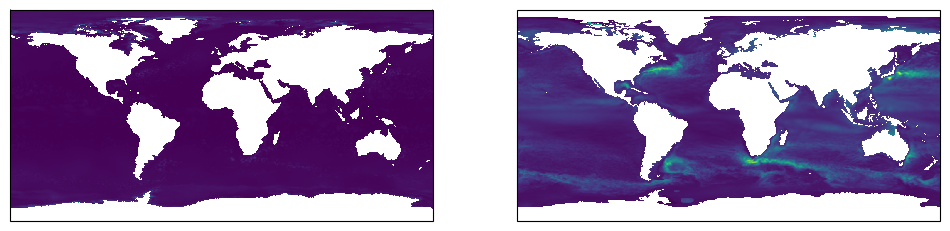

In [29]:
lon = aviso.longitude.values
lat = aviso.latitude.values

lons = icon.lon.values
lats = icon.lat.values

# # Replace the latitude and longitude values in the dataset
#icon.coords['lat'] = lat
#icon.coords['lon'] = lon

#icon = icon.reindex_like(aviso, method='nearest')

#icon = icon.where(icon.lat < 70)
#icon = icon.where(icon.lat > -62)
#levels = [0.0, 1.0, 2.0, 3.0]

fig, axes = plt.subplots(1, 2, figsize=(12, 5), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})
contour1 = axes[0].pcolormesh(lons, lats, masked_data, cmap='viridis')
contour2 = axes[1].pcolormesh(lon, lat, aviso, cmap='viridis')
#plt.show()

In [28]:
# for i, (model_name, data) in enumerate(ssh_data_dict.items()):
#     if i < len(axes):
#         ax = axes[i]
#         if 'lon' in data.coords:
#             contf = ax.contourf(data.lon.values, data.lat.values, data, transform=ccrs.PlateCarree(), vmin=0.1, vmax=0.4)
#         else:
#             contf = ax.contourf(data.longitude.values, data.latitude.values, data, transform=ccrs.PlateCarree(), vmin=0.1, vmax=0.4)
#     plt.show()
    
    
    

    
    
    
    
#def visualize_subplots(config, ssh_data_dict, fig, axes):
for i, (model_name, data) in enumerate(ssh_data_dict.items()):
    print(data)
    if i < len(axes):
        ax = axes[i]


        # # Apply masking if the model is "ICON" and the flags are enabled with boundary latitudes provided
        # if "ICON" in model_name and mask_northern_boundary and northern_boundary_latitude:
        #     data = data.where(data.lat < northern_boundary_latitude)
        # if "ICON" in model_name and mask_southern_boundary and southern_boundary_latitude:
        #     data = data.where(data.lat > southern_boundary_latitude)
        # Create a contour plot on the current axis
        levels = np.linspace(
            config["subplot_options"]["scale_min"], config["subplot_options"]["scale_max"], num=100)
        if 'lon' in data.coords:
            contf = ax.contourf(data.lon.values, data.lat.values, data, transform=ccrs.PlateCarree(), vmin=0.1, vmax=0.4)
        else:
            contf = ax.contourf(data.longitude.values, data.latitude.values, data, transform=ccrs.PlateCarree(), vmin=0.1, vmax=0.4)
        ax.set_title(f"{model_name}")
        ax.coastlines()               

            # Add a colorbar for each subplot
        cbar = fig.colorbar(contf, ax=ax, orientation='vertical', shrink=0.9)
        cbar.set_label('SSH Variability (mm)')
    if len(ssh_data_dict) < len(axes):
        for j in range(len(ssh_data_dict), len(axes)):
            fig.delaxes(axes[j])
    fig.tight_layout()

In [29]:
visualize_subplots(config, ssh_data_dict, fig, axes)

NameError: name 'ssh_data_dict' is not defined

In [83]:
#def visualize_subplots(config, ssh_data_dict, fig, axes):
for i, (model_name, data) in enumerate(ssh_data_dict.items()):
    if i < len(axes):
        ax = axes[i]


        # # Apply masking if the model is "ICON" and the flags are enabled with boundary latitudes provided
        # if "ICON" in model_name and mask_northern_boundary and northern_boundary_latitude:
        #     data = data.where(data.lat < northern_boundary_latitude)
        # if "ICON" in model_name and mask_southern_boundary and southern_boundary_latitude:
        #     data = data.where(data.lat > southern_boundary_latitude)
        # Create a contour plot on the current axis
        levels = np.linspace(
            config["subplot_options"]["scale_min"], config["subplot_options"]["scale_max"], num=100)
        if 'lon' in data.coords:
            contf = ax.pcolormesh(data.lon.values, data.lat.values, data, transform=ccrs.PlateCarree(), 
                              vmin=config["subplot_options"]["scale_min"], vmax=config["subplot_options"]["scale_max"], 
                              cmap=config["subplot_options"]["cmap"])
        else:
            contf = ax.pcolormesh(data.longitude.values, data.latitude.values, data, transform=ccrs.PlateCarree(), 
                              vmin=config["subplot_options"]["scale_min"], vmax=config["subplot_options"]["scale_max"], 
                              cmap=config["subplot_options"]["cmap"])
        ax.set_title(f"{model_name}")
        ax.coastlines()               

        # Add a colorbar for each subplot
        cbar = fig.colorbar(contf, ax=ax, orientation='vertical', shrink=0.9)
        cbar.set_label('SSH Variability (mm)')
    if len(ssh_data_dict) < len(axes):
        for j in range(len(ssh_data_dict), len(axes)):
            fig.delaxes(axes[j])
    fig.tight_layout()


<xarray.DataArray 'adt' (latitude: 720, longitude: 1440)>
dask.array<_sqrt, shape=(720, 1440), dtype=float64, chunksize=(720, 1440), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * longitude  (longitude) float32 -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
Attributes:
    comment:        The absolute dynamic topography is the sea surface height...
    grid_mapping:   crs
    long_name:      Absolute dynamic topography
    standard_name:  sea_surface_height_above_geoid
    units:          m
<xarray.DataArray 'zos' (lat: 720, lon: 1440)>
dask.array<reshape, shape=(720, 1440), dtype=float64, chunksize=(720, 1440), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float64 0.0 0.25 0.5 0.75 1.0 ... 359.0 359.2 359.5 359.8
Attributes:
    description:  sea surface elevation
    long_name:    Sea surface height
    units:        m
    history

CancelledError: ('reshape-7f7d6f922b69c3eeeb9aec3cfaa3430c', 0, 0)

In [122]:
visualize_subplots(config, ssh_data_dict, fig, axes)

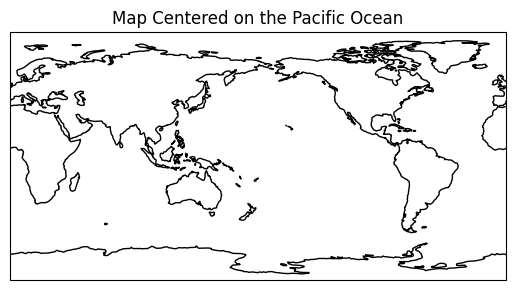

In [179]:
# Create a figure and axis with PlateCarree projection centered on the Pacific
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})

ax.coastlines()

# Set the title
ax.set_title('Map Centered on the Pacific Ocean')

# Show the plot
plt.show()

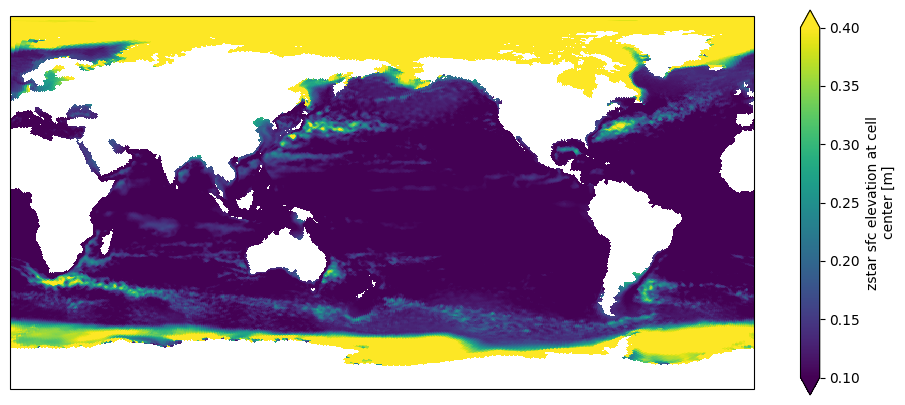

In [212]:
fig, ax = plt.subplots(figsize=(12, 5), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})

icon.plot(vmin=0.1,vmax=0.4)

In [93]:
print(aviso.longitude)
print(icon.lon)

<xarray.DataArray 'longitude' (longitude: 1440)>
array([-179.875, -179.625, -179.375, ...,  179.375,  179.625,  179.875],
      dtype=float32)
Coordinates:
  * longitude  (longitude) float32 -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
Attributes:
    axis:           X
    bounds:         lon_bnds
    long_name:      Longitude
    standard_name:  longitude
    units:          degrees_east
    valid_max:      179.875
    valid_min:      -179.875
<xarray.DataArray 'lon' (lon: 1440)>
array([0.0000e+00, 2.5000e-01, 5.0000e-01, ..., 3.5925e+02, 3.5950e+02,
       3.5975e+02])
Coordinates:
  * lon      (lon) float64 0.0 0.25 0.5 0.75 1.0 ... 359.0 359.2 359.5 359.8
Attributes:
    units:          degrees_east
    standard_name:  longitude
    axis:           X


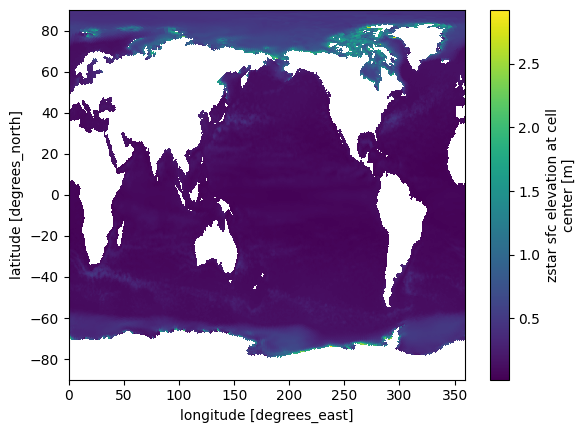

In [65]:
if 'lon' in data.coords:
    contf = ax.contourf(data.lon, data.lat, data, transform=ccrs.PlateCarree(), 
    vmin=config["subplot_options"]["scale_min"], vmax=config["subplot_options"]["scale_max"], 
    cmap=config["subplot_options"]["cmap"])
else:
    contf = ax.contourf(data.longitude, data.latitude, data, transform=ccrs.PlateCarree(), 
    vmin=config["subplot_options"]["scale_min"], vmax=config["subplot_options"]["scale_max"], 
    cmap=config["subplot_options"]["cmap"])
ax.set_title(f"{model_name}")
ax.coastlines()

CPU times: user 39.7 ms, sys: 6.71 ms, total: 46.4 ms
Wall time: 62.8 ms


Text(0.5, 0.98, 'SSH Variability')

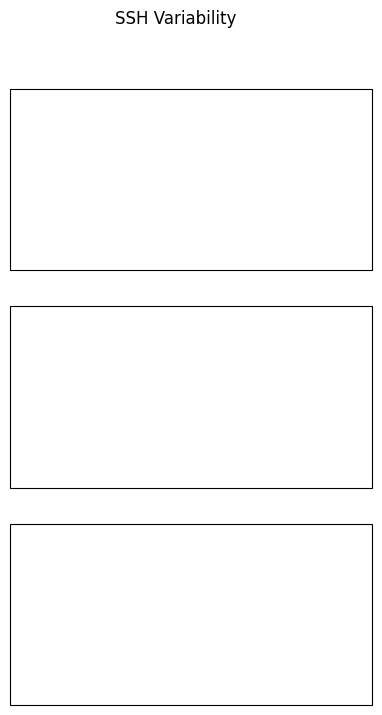

In [42]:
%%time

fig, axes = plt.subplots(nrows=len(config['models'])+1, ncols=1, figsize=(
            12, 8), subplot_kw={'projection': ccrs.PlateCarree()})
fig.suptitle("SSH Variability")

#visualize_subplots(config, ssh_data_dict, fig, axes)
#plt.savefig('ff1.pdf')

In [36]:
def run():
        """
        Run the sshVariability.
        """
        # Load the configuration - reading and parsing the YAML configuration file.
        config = util.load_yaml('../config1.yml')

        # Comparing user timespan inputs across the models
        validate_time_ranges(config)

        # Initialize the Dask cluster
        cluster = dd.LocalCluster(**config['dask_cluster'])
        client = dd.Client(cluster)
        # Get the Dask dashboard URL
        logger.info("Dask Dashboard URL: %s", client.dashboard_link)

        # logger.info(f"Dask Dashboard URL: {client.dashboard_link}")

        workers = client.scheduler_info()["workers"]
        worker_count = len(workers)
        total_memory = format_bytes(
            sum(w["memory_limit"] for w in workers.values() if w["memory_limit"]))
        memory_text = f"Workers={worker_count}, Memory={total_memory}"
        logger.info(memory_text)

        # Load AVISO data and get its time span
        # idea: think in context of streaming data.
        try:
            reader = Reader(model=config['base_model']['name'], exp=config['base_model']
                        ['experiment'], source=config['base_model']['source'], fix=True)
        except:
            raise NoObservationError("AVISO data not found.")

        aviso_cat = reader.retrieve()

        aviso_time_min = np.datetime64(aviso_cat.time.min().values)
        aviso_time_max = np.datetime64(aviso_cat.time.max().values)
        logger.info("AVISO data spans from %s to %s",
                    aviso_time_min, aviso_time_max)

        # Absolute dynamic topography, sea_surface_height_above_geoid
        aviso_ssh = aviso_cat['adt']

        logger.info("Now computing std on AVISO ssh for the provided timespan")
        # Get the user-defined timespan from the configuration
        timespan_start = config['timespan']['start']
        timespan_end = config['timespan']['end']

        if not check_time_span(aviso_ssh, timespan_start, timespan_end):
            raise NotEnoughDataError("The time span is not within the range of time steps in the xarray object.")
            sys.exit(0)

        logger.info("Now computing std on AVISO ssh for the provided timespan")
        
        
        aviso_ssh_std = aviso_ssh.sel(time=slice(
            timespan_start, timespan_end)).std(axis=0).persist()
        # saving the computation in output files
        logger.info("computation for AVISO ssh complete, saving output file")
        #save_standard_deviation_to_file(create_output_directory(
        #    config), "AVISO_ssh-L4_daily", aviso_ssh_std)

        ssh_data_dict = {}
        # ssh_data_dict[config['base_model']['name']] = aviso_ssh_std
        ssh_data_dict[f"{config['base_model']['name']}:{config['base_model']['experiment']} {timespan_start} to {timespan_end}"] = aviso_ssh_std

        # Create a figure and axes for subplots
        fig, axes = plt.subplots(nrows=len(config['models'])+1, ncols=1, figsize=(
            12, 8), subplot_kw={'projection': ccrs.PlateCarree()})
        fig.suptitle("SSH Variability")

        # By applying np.ravel() to the axes object, it flattens the 2-dimensional array into a 1-dimensional array. This means that each subplot is now accessible through a single index, rather than using row and column indices.
        # This reshaping of the axes object allows for easier iteration over the subplots when visualizing or modifying them, as it simplifies the indexing and looping operations.
        axes = np.ravel(axes)
        logger.info(
            "Now loading data for other models to compare against AVISO ssh variability")
        for model_name in config['models']:

            logger.info(
                "initializing AQUA reader to read the model inputs for %s", model_name)

            try:
                reader = Reader(model=model_name['name'], exp=model_name['experiment'],
                            source=model_name['source'], regrid=model_name['regrid'], zoom=model_name['zoom'], fix=True)
            except:
                raise NoDataError("Model data not found.")
            
            model_data = reader.retrieve()

            ssh_data = model_data[model_name['variable']]

            model_data_time_min = np.datetime64(model_data.time.min().values)
            model_data_time_max = np.datetime64(model_data.time.max().values)
            logger.info("%s data spans from %s to %s",
                        model_name['name'], model_data_time_min, model_data_time_max)

            logger.info("Getting SSH data complete for %s, now computing standard deviation on the default timestamp",
                        model_name['name'])
            # computing std
            
            if 'timespan' in model_name and model_name['timespan']:
                if not check_time_span(ssh_data, model_name['timespan'][0], model_name['timespan'][1]):
                    raise NotEnoughDataError("The time span is not within the range of time steps in the xarray object.")
                    sys.exit(0)
                timespan_start = parse(model_name['timespan'][0])
                timespan_end = parse(model_name['timespan'][1])

            else:
                warnings.warn(
                    "Model does not have a custom timespan, using default.", UserWarning)
                if not check_time_span(ssh_data, config['timespan']['start'], config['timespan']['end']):
                    raise NotEnoughDataError("The time span is not within the range of time steps in the xarray object.")
                    sys.exit(0)
                timespan_start = config['timespan']['start']
                timespan_end = config['timespan']['end']

            ssh_std_dev_data = ssh_data.sel(time=slice(timespan_start, timespan_end)).std(
                axis=0, keep_attrs=True).persist()


            logger.info("computation complete, saving output file")
            # saving the computation in output files
            model_info = f"{model_name['name']}_{model_name['experiment']}_{model_name['source']}"
            #save_standard_deviation_to_file(
             #   self.create_output_directory(config), model_info, ssh_std_dev_data)
            # self.save_standard_deviation_to_file(config['output_directory'], model_name['name'], ssh_std_dev_data)

            logger.info(
                "output saved, now regridding using the aqua regridder")
            # regridding the data and plotting for visualization
            ssh_std_dev_regrid = reader.regrid(ssh_std_dev_data)
            # ssh_data_dict[model_name['name']] = ssh_std_dev_regrid
            ssh_data_dict[f"{model_name['name']}:{model_name['experiment']} {model_name['timespan'][0]} to {model_name['timespan'][1]}"] = ssh_std_dev_regrid

        logger.info("visualizing the data in subplots")
        # self.visualize_subplots(config, ssh_data_list, fig, axes)
        visualize_subplots(config, ssh_data_dict, fig, axes)

        logger.info("Saving plots as a PDF output file")
        # self.save_subplots_as_jpeg(config, "subplots_output.jpeg", fig)
        save_subplots_as_pdf("ssh_all_models_ssh-variablity.pdf", fig)

            




In [37]:
run()

2023-11-07 15:29:59 :: ssh_logger :: WARNING  -> Time ranges are not equal across models.
/home/a/a270238/conda/envs/aqua_common/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 44809 instead
  warnings.warn(
2023-11-07 15:30:01 :: ssh_logger :: INFO     -> Dask Dashboard URL: http://127.0.0.1:44809/status
2023-11-07 15:30:01 :: ssh_logger :: INFO     -> Workers=16, Memory=100.00 GiB
2023-11-07 15:30:01 :: Reader :: WARNING  -> No fixes available for model AVISO
2023-11-07 15:30:01 :: ssh_logger :: INFO     -> AVISO data spans from 1993-01-01T00:00:00.000000000 to 2022-06-23T00:00:00.000000000
2023-11-07 15:30:01 :: ssh_logger :: INFO     -> Now computing std on AVISO ssh for the provided timespan
;1m2023-11-07 15:30:01 :: ssh_logger :: DEBUG    -> start_date: 2015-01-20 00:00:00
;1m2023-11-07 15:30:01 :: ssh_logger :: DEBUG    -> end_date: 2021-12-31 00:00:00
;1m2

TypeError: 'GeometryCollection' object is not subscriptable

Error in callback <function _draw_all_if_interactive at 0x7ffdf48a4cc0> (for post_execute):


TypeError: 'GeometryCollection' object is not subscriptable

TypeError: 'GeometryCollection' object is not subscriptable

<Figure size 1200x800 with 4 Axes>

In [21]:
ssh_data_dict

{'AVISO:ssh-L4 2020-06-21 00:00:00 to 2020-07-23 00:00:00': <xarray.DataArray 'adt' (latitude: 720, longitude: 1440)>
 dask.array<_sqrt, shape=(720, 1440), dtype=float64, chunksize=(720, 1440), chunktype=numpy.ndarray>
 Coordinates:
   * latitude   (latitude) float32 -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
   * longitude  (longitude) float32 -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
 Attributes:
     comment:        The absolute dynamic topography is the sea surface height...
     grid_mapping:   crs
     long_name:      Absolute dynamic topography
     standard_name:  sea_surface_height_above_geoid
     units:          m}

In [19]:
for model_name in config['models']:
    ssh_data = model_data[model_name['variable']]
    ssh_std_dev_data = ssh_data.sel(time=slice(timespan_start, timespan_end)).std(
                axis=0, keep_attrs=True).persist()
    ssh_std_dev_regrid = reader.regrid(ssh_std_dev_data)

    ssh_data_dict[f"{model_name['name']}:{model_name['experiment']} {model_name['timespan'][0]} to {model_name['timespan'][1]}"] = ssh_std_dev_regrid
            # ssh_data_dict[model_name['name']] = ssh_std_dev_regrid
    for i, (model_name, data) in enumerate(ssh_data_dict.items()):
        print(model_name)
        if i < len(axes):
            ax = axes[i]


AVISO:ssh-L4 2015-01-20 to 2021-12-31
ICON:ngc3028 2020-06-21 to 2020-07-23


/home/a/a270238/conda/envs/aqua_common/lib/python3.11/site-packages/dask/array/numpy_compat.py:43: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


In [20]:
ssh_data_dict

{'AVISO:ssh-L4 2015-01-20 to 2021-12-31': <xarray.DataArray 'adt' (latitude: 720, longitude: 1440)>
 dask.array<_sqrt, shape=(720, 1440), dtype=float64, chunksize=(720, 1440), chunktype=numpy.ndarray>
 Coordinates:
   * latitude   (latitude) float32 -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
   * longitude  (longitude) float32 -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
 Attributes:
     comment:        The absolute dynamic topography is the sea surface height...
     grid_mapping:   crs
     long_name:      Absolute dynamic topography
     standard_name:  sea_surface_height_above_geoid
     units:          m,
 'ICON:ngc3028 2020-06-21 to 2020-07-23': <xarray.DataArray 'zos' (lat: 720, lon: 1440)>
 dask.array<reshape, shape=(720, 1440), dtype=float64, chunksize=(720, 1440), chunktype=numpy.ndarray>
 Coordinates:
   * lat      (lat) float64 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
   * lon      (lon) float64 0.0 0.25 0.5 0.75 1.0 ... 359.0 359.2 359.5 359.8
 Attributes:
     cel

In [26]:
data.lon

<xarray.DataArray 'lon' (lon: 1440)>
array([0.0000e+00, 2.5000e-01, 5.0000e-01, ..., 3.5925e+02, 3.5950e+02,
       3.5975e+02])
Coordinates:
  * lon      (lon) float64 0.0 0.25 0.5 0.75 1.0 ... 359.0 359.2 359.5 359.8
Attributes:
    units:          degrees_east
    standard_name:  longitude
    axis:           X

In [33]:
%%time

fig, axes = plt.subplots(nrows=len(config['models'])+1, ncols=1, figsize=(
            12, 8), subplot_kw={'projection': ccrs.PlateCarree()})
fig.suptitle("SSH Variability")

visualize_subplots(config, ssh_data_dict, fig, axes)
#plt.savefig('ff1.pdf')

TypeError: 'GeometryCollection' object is not subscriptable

Error in callback <function _draw_all_if_interactive at 0x7ffdf48a9760> (for post_execute):


TypeError: 'GeometryCollection' object is not subscriptable

TypeError: 'GeometryCollection' object is not subscriptable

<Figure size 1200x800 with 3 Axes>

In [30]:
for i, (model_name, data) in enumerate(ssh_data_dict.items()):
        if i < len(axes):
            ax = axes[i]

            # Apply masking if the model is "ICON" and the flags are enabled with boundary latitudes provided
            mask_northern_boundary = config.get("mask_northern_boundary", False)
            mask_southern_boundary = config.get("mask_southern_boundary", False)
            northern_boundary_latitude = config.get("northern_boundary_latitude", None)
            southern_boundary_latitude = config.get("southern_boundary_latitude", None)
            if "ICON" in model_name and mask_northern_boundary and northern_boundary_latitude:
                data = data.where(data.lat < northern_boundary_latitude)
            if "ICON" in model_name and mask_southern_boundary and southern_boundary_latitude:
                data = data.where(data.lat > southern_boundary_latitude)


In [117]:
data.lat

<xarray.DataArray 'lat' (lat: 720)>
array([-89.875, -89.625, -89.375, ...,  89.375,  89.625,  89.875])
Coordinates:
  * lat      (lat) float64 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
Attributes:
    units:          degrees_north
    standard_name:  latitude
    axis:           Y